In [151]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from VFAE_functions import *

%matplotlib inline

# Load and clean the data

In [ ]:
df = pd.read_csv('data/OH.csv')

### These are the columns that will be used in the model

In [ ]:
workable_cols = ['stop_date','stop_time','location_raw','driver_gender','driver_race','driver_race_raw','violation',
                 'search_conducted','contraband_found','is_arrested','drugs_related_stop']

df_reduced = df[workable_cols]

### Convert time into hours and date into month

In [ ]:
df_reduced['stop_hour'] = df_reduced['stop_time'].apply(lambda x: x.split(':')[0])
df_reduced['stop_month'] = df_reduced['stop_date'].apply(lambda x: x.split('-')[1])
df_reduced.drop('stop_time',axis=1,inplace=True)
df_reduced.drop('stop_date',axis=1,inplace=True)

### There are around 90 different location, but the most frequent 20 account ~90% of all cases. To minimize the sparseness of the dataset, we save the 20 most frequent locations, and set the remainder to null, to be imputed later

In [ ]:
print(df_reduced['location_raw'].value_counts()[:20].sum()/df_reduced.shape[0])
keep_locations = list(df_reduced['location_raw'].value_counts().keys()[:20])
df_reduced['location_raw'] = df_reduced['location_raw'].apply(lambda x: int(x) if x in keep_locations else None)

### There are two columns for driver race. We take the values which are 'other' in one, and replace them with the values in the second column.

In [ ]:
df_reduced['driver_race'].loc[df_reduced['driver_race']=='Other'] = df_reduced['driver_race_raw'].loc[df_reduced['driver_race']=='Other']
df_reduced.drop('driver_race_raw',axis=1,inplace=True)

### The violations column includes lists of 'violations' allegedly perpetrated by each person. We want to turn these lists into numerical values, to be able to use 'violations' in a model. Thankfully, there is a realtively small number of unique violations

In [ ]:
violations_unique = []
for l in df_reduced['violation'].dropna().unique():
    violations_unique = violations_unique + l.lower().split(',')
violations_unique = set(violations_unique)
print(violations_unique)

### We create a mapping between each violation and integer values, and rank these from worst to least (which is an objective definition).
### The worst one will be selected in each row

In [ ]:
df_reduced['violations_numbered'] = df_reduced['violation'].fillna('other (non-mapped)').apply(violations_denoter)
df_reduced.drop('violation',axis=1,inplace=True)

### We need to turn categorical features into binary columns
### The first step is to impute null values with values drawn from a probability distribution of the other values in each column

In [ ]:
categorical = list(df_reduced.columns)
categorical.remove('is_arrested')

In [ ]:
for c in categorical:
    df_reduced = replace_na_categorical(df_reduced,c)

### Generate dummy variables for each categorical feature (which is all of them in this case)
### This is now the final version of the data, that is ready to be analyzed using a machine learning model

In [ ]:
df_clean = pd.get_dummies(df_reduced,columns=categorical)
df_sampled_clean = dummy.sample(frac=0.1,random_state=2018).reset_index(drop=True)

## Set up the model training and testing

### Split the data into a training and testing set

In [ ]:
df = df_clean

In [123]:
df_train, df_test = train_test_split(df,test_size=0.3)

### Define the target feature

In [94]:
target_feature = 'is_arrested'

In [124]:
train_X = np.asarray(df_train.drop([target_feature],axis=1))
train_Y = np.asarray(df_train[target_feature]).astype(int)

test_X = np.asarray(df_test.drop([target_feature],axis=1))
test_Y = np.asarray(df_test[target_feature]).astype(int)

F1 score = 0.21681723419
Precision score = 0.555160142349
Recall score = 0.134715025907
Accuracy score = 0.993907449454

Discrimination_ratio = 3.256294240669241



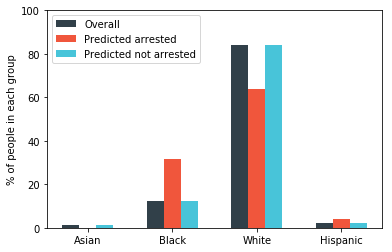

In [127]:
params = {'n_jobs': -1, 'n_estimators': 47, 'max_depth': 8, 'criterion': 'gini', 'class_weight': None}
weights = np.ones(train_Y.shape[0])
weights[train_Y==1] = 1.
weights[train_Y==0] = 0.5
RFC = run_clf('RFC',train_X,train_Y,params,weights=weights)
bias = check_error_and_discrimination(RFC,test_X,test_Y,df_test,sensitive_features)
df_bias = pd.DataFrame(bias).transpose()
df_bias.columns = ["Group","N_group/N_total","N_group/N_total|(predicted arrest)","N_group/N_total|(predicted not arrest)"]
plot_distribution(df_bias)

### We use 'driver_race_Black' as the sensitive feature, given the severe bias of the model against this group of people

In [ ]:
sensitive_features = ['driver_race_Black']

## Begin setting up the VFAE

### Split the dataset into a training and cross-validation sets, to determine the optimal hyperparameters for the VFAE

In [263]:
df_VFAE_train, df_VFAE_CV = train_test_split(df,test_size=0.5)
df_VFAE_CV, df_VFAE_test = train_test_split(df_VFAE_CV,test_size=0.75)

df_VFAE_train = df_VFAE_train.reset_index(drop=True)
df_VFAE_CV = df_VFAE_CV.reset_index(drop=True)
df_VFAE_test = df_VFAE_test.reset_index(drop=True)

VFAE_train_X, VFAE_train_Y, VFAE_train_s = obtain_X_Y_s(df_VFAE_train,target_feature,sensitive_features)
VFAE_CV_X, VFAE_CV_Y, VFAE_CV_s = obtain_X_Y_s(df_VFAE_CV,target_feature,sensitive_features)
VFAE_test_X, VFAE_test_Y, VFAE_test_s = obtain_X_Y_s(df_VFAE_test,target_feature,sensitive_features)

### Perform a hyperparameter search

In [ ]:
tf.reset_default_graph()

# Hidden units in the hidden layers
# [z1, z2, encoding1, encoding2, decoding1, decoding2, unsupervised]
hidden_dim_list = [
    [20,20,50,50,50,50,50]
]

lr_list = [1e-3,1e-2]

alpha_list = [1e-1,1e0,1e1]

batch_size_list = [1000,10000]

beta_list = [1e-1,1e0,1e1]

D_list = [50,100,200]

loss_min = 1e3

for hd in hidden_dim_list:
    
    for lr in lr_list:
        
        for alpha in alpha_list:
            
            for bs in batch_size_list:
                
                for beta in beta_list:
                    
                    for D in D_list:
        
                        print("Begin analysis for dims = %s, lr = %s, alpha = %s, batch size = %s, beta = %s, D = %s:"/
                              %(hd,lr,alpha,bs,beta,D))

                        dims = {
                            'x':VFAE_train_X.shape[1],
                            'y_cat':len(np.unique(VFAE_train_Y)),
                            's':VFAE_train_s.shape[1],
                            'z1':hd[0],
                            'z2':hd[1],
                            'enc1_hid':hd[2],
                            'enc2_hid':hd[3],
                            'dec1_hid':hd[4],
                            'dec2_hid':hd[5],
                            'us_hid':hd[6]
                        }

                        params = initialize_params(dims,N_epochs=10,lr=lr,print_freq=5,batch_size=bs,
                                                   alpha=alpha,beta=beta,D=D,gamma=1)
                        weights, bias = initialize_weights_biases(params)
                        enc_X, latent_X, loss, LH_x = train_VFAE(VFAE_train_X,VFAE_train_Y,VFAE_train_s,
                                                                 VFAE_CV_X,VFAE_CV_Y,VFAE_CV_s,
                                                                 weights,bias,params,dims)

                        print("The CV global loss = %s and reconstruction loss and = %s"%(loss,LH_x))
                        print()
                        print()

                        if (np.abs(LH_x) < loss_min):
                            loss_min = np.abs(LH_x)
                            d_optimal = hd
                            lr_optimal = lr
                            alpha_optimal = alpha
                            bs_optimal = bs
                            beta_optimal = beta
                            D_optimal = D
                            latent_X_optimal = latent_X
                    
print("The minimum loss of %s was obtained using dims = %s, lr = %s, alpha = %s, bs = %s, beta = %s, D = %s"/
      %(loss_min,d_optimal,lr_optimal,alpha_optimal,bs_optimal,beta_optimal,D_optimal))            

### Run the VFAE with the test set using the optimal hyperparameters

In [212]:
# Run with the optimal params
dims = {
    'x':VFAE_train_X.shape[1],
    'y_cat':len(np.unique(VFAE_train_Y)),
    's':VFAE_train_s.shape[1],
    'z1':d_optimal[0],
    'z2':d_optimal[1],
    'enc1_hid':d_optimal[2],
    'enc2_hid':d_optimal[3],
    'dec1_hid':d_optimal[4],
    'dec2_hid':d_optimal[5],
    'us_hid':d_optimal[6]
}

params = initialize_params(dims,N_epochs=20,lr=lr_optimal,print_freq=10,batch_size=bs_optimal,alpha=alpha_optimal,beta=beta_optimal,D=D_optimal,gamma=1.)
weights, bias = initialize_weights_biases(params)
enc_X, latent_X, loss, LH_x = train_VFAE(VFAE_train_X,VFAE_train_Y,VFAE_train_s,VFAE_test_X,VFAE_test_Y,VFAE_test_s,weights,bias,params,dims)

/Users/yevgenik/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: batch loss = 15.5253 and global loss = 16.5807
KL_z1 = 0.968424, KL_z2 = 0.384209, RL = -16.9511, unsupervised posterior = -22.8647, MMD = 1.01463
Epoch 10: batch loss = 13.268 and global loss = 13.2127
KL_z1 = 0.0505597, KL_z2 = 0.000966574, RL = -15.4028, unsupervised posterior = -22.8647, MMD = 0.00922411


### Split the test set and resulting latent representation into training and test sets, to be used in a classification model

In [267]:
train_index, test_index = train_test_split(np.arange(VFAE_test_X.shape[0]),test_size=0.3)
clf_train_X, clf_test_X = VFAE_test_X[train_index], VFAE_test_X[test_index]
clf_train_Y, clf_test_Y = VFAE_test_Y[train_index].ravel(), VFAE_test_Y[test_index].ravel()
clf_train_s, clf_test_s = VFAE_test_s[train_index], VFAE_test_s[test_index]
df_train, df_test = df_VFAE_test.loc[train_index], df_VFAE_test.loc[test_index]

train_latent_X, test_latent_X = latent_X[train_index], latent_X[test_index]

F1 score = 0.230942872026
Precision score = 0.538461538462
Recall score = 0.146993810787
Accuracy score = 0.993615165603

Discrimination_ratio = 1.8552219649734132



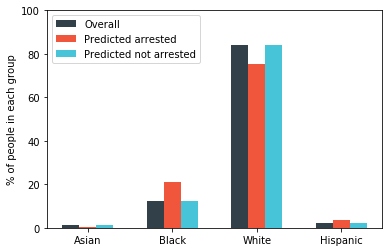

In [222]:
params = {'n_jobs': -1, 'n_estimators': 47, 'max_depth': 8, 'criterion': 'gini', 'class_weight': None}
weights = np.ones(clf_train_Y.shape[0])
weights[clf_train_Y==1] = 1.
weights[clf_train_Y==0] = 0.5
RFC = run_clf('RFC',train_latent_X,clf_train_Y,params,weights=weights)
bias = check_error_and_discrimination(RFC,test_latent_X,clf_test_Y,df_test,sensitive_features)
df_bias = pd.DataFrame(bias).transpose()
df_bias.columns = ["Group","N_group/N_total","N_group/N_total|(predicted arrest)","N_group/N_total|(predicted not arrest)"]
plot_distribution(df_bias)